In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install colorthief

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt    
import seaborn as sns

from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.util import img_as_ubyte
from skimage import io

from colorthief import ColorThief
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
path_mp4 = '/content/drive/MyDrive/interviews/belka/foam.mp4'

In [ ]:
my_threshold = 130

In [ ]:
def get_frames(video_file, folder_name):
  
  if not os.path.exists(folder_name):
    os.makedirs(folder_name)

  count = 0
  cap = cv2.VideoCapture(video_file)   # загрузка видео 
  frameRate = cap.get(5) # частота кадров
  while(cap.isOpened()):
    frameId = cap.get(1) # номер текущего кадра
    ret, frame = cap.read()
    if ret:
      filename ="frame%d.jpg" % count
      count+=1
      directory = os.path.join(folder_name, filename)
      cv2.imwrite(directory, frame)
    else:
      break

  cap.release()
  cv2.destroyAllWindows()

In [ ]:
def crop_frames(path_folder):
  # подсчет числа файлов, подлежащих обрезке
  files = os.listdir(path_folder)
  num_imgs = len(files)

  # создание папки для новых файлов  
  new_folder = 'foam_crop'
  if not os.path.exists(new_folder):
    os.makedirs(new_folder)

  for id_img in range(num_imgs):
    # открытие файла
    path = os.path.join(path_folder, "frame%d.jpg" % id_img)
    img = cv2.imread(path)
    img_gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = img_as_ubyte(img_gr)

    # обнаружение края
    edges = canny(image, sigma=2)
    #image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

    # обнаружение одного радиуса в интервале от 120 до 200 с шагом 1
    hough_radii = np.arange(120, 200, 1)
    hough_res = hough_circle(edges, hough_radii)

    # Выбор самого подходящего радиуса
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                              total_num_peaks=1)

    # создание нового "пустого" изображения
    h,w,_ = img.shape
    mask = np.zeros((h,w), np.uint8)

    # изображение круга
    cv2.circle(mask, (cx[0],cy[0]), radii[0], 255, -1)

    # наложение маски
    crop_img = cv2.bitwise_and(img, img, mask= mask)
    
    # обрезка края по пользовательским координатам 
    x_min, x_max = 150, 560
    y_min, y_max = 70, 490
    crop_img = crop_img[y_min:y_max, x_min:x_max]
  
    # сохранение файла
    directory = os.path.join(new_folder, "frame_crop%d.jpg" % id_img)
    cv2.imwrite(directory, crop_img)

In [ ]:
def lab_graph(path_img, threshold_img):
  # создание папки для графиков
  new_folder = 'graphs'
  if not os.path.exists(new_folder):
    os.makedirs(new_folder)

  img = cv2.imread(path_img)
  img_rgba = cv2.cvtColor(img,cv2.COLOR_BGR2RGBA)
  img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  y,x,z = img_lab.shape
  
  # очистка изображений от черных  и бликовых пикселей  по их id
  id_black = np.where(img_rgba[:,:,-1] == 0)
  id_white = np.where(threshold_img[:,:] == 255)

  id_del_x = np.concatenate((id_black[0], id_white[0]))
  id_del_y = np.concatenate((id_black[1], id_white[1]))
  id_del_x, id_del_y = np.sort(id_del_x), np.sort(id_del_y)

  img_lab_2d = img_lab.reshape((y*x,z))
  lab_clear = img_lab_2d.copy()

  img_rgba_2d = img_rgba.reshape((y*x,4))
  rgba_clear = img_rgba_2d.copy()
  # удаление строк начиная снизу
  for id_x, id_y in zip(id_del_x[::-1], id_del_y[::-1]):
    #номер строки для удаления с учётом изменения размерности
    id_del = id_x*x+id_y
    lab_clear = np.concatenate((lab_clear[:id_del],lab_clear[id_del+1:]), axis = 0)
    rgba_clear = np.concatenate((rgba_clear[:id_del],rgba_clear[id_del+1:]), axis = 0)

  colors = rgba_clear/255

  fig = plt.figure(figsize = (20,30))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(xs=lab_clear[:,2], ys=lab_clear[:,1], zs=lab_clear[:,0],
             s=10,  c=colors, lw=0)
  ax.set_xlabel('A')
  ax.set_ylabel('B')
  ax.set_zlabel('L')

  #plt.show()
  id_img = int(path_img.split('crop')[-1].split('.')[0])
  plt.savefig(os.path.join(new_folder, "plot_LAB%d.png" % id_img))
  plt.close()

In [ ]:
def monitoring(path_folder):
  # подсчет числа файлов для мониторинга
  files = os.listdir(path_folder)
  num_imgs = len(files)

  highlights_size = []
  num_highlight = []
  palette = []

  for id_img in range(num_imgs):
    # открытие файла
    path = os.path.join(path_folder, "frame_crop%d.jpg" % id_img)
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Расчет количества бликованных пикселей 
    # так как на видео освещение равномерное и не меняется,
    # то граница для всех фреймов будет константой, определенной опытным путём
    # по гистограмме ax.hist(img_gray.ravel(), bins=255)
    threshold=my_threshold
    _,threshold_img = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY)
    highlights_size_img = np.count_nonzero(threshold_img)
    highlights_size.append(highlights_size_img)

    # Расчет количества бликов
    # координаты точек не нужны, поэтому аппроксимация методом Simple
    # для бликов, которые могут быть многослойны, скорее всего, нужен режим поиска
    # контуров RETR_TREE, который восстанавливает полную иерархию вложенных контуров
    contours, hier = cv2.findContours(threshold_img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    count = len(contours)
    num_highlight.append(count)
    
    # Определение цвета пены
    color_thief = ColorThief(path)
    palette_img = color_thief.get_palette(color_count=3)
    palette.append(palette_img[1]) # под нулевым индексом преобладающий цвет маски (чёрный)

    # Построение LAB-графика и сохранение в отдельный файл
    lab_graph(path, threshold_img)

  return highlights_size, num_highlight, palette

In [ ]:
get_frames(path_mp4, 'foam_data')

In [ ]:
crop_frames('/content/foam_data/')

In [ ]:
highlights_size, num_highlight, palette = monitoring('/content/foam_crop/')

In [ ]:
df = pd.DataFrame(list(zip(highlights_size, num_highlight, palette)),columns =['size', 'number', 'main_color'])

In [ ]:
df

,size,number,main_color
0,8170,619,"(174, 164, 188)"
1,8048,562,"(182, 172, 196)"
2,8152,588,"(182, 173, 196)"
3,8148,562,"(180, 171, 195)"
4,8024,612,"(179, 169, 193)"
...,...,...,...
161,8371,716,"(177, 167, 191)"
162,8338,647,"(177, 167, 191)"
163,8416,670,"(171, 162, 186)"
164,7957,626,"(170, 161, 185)"


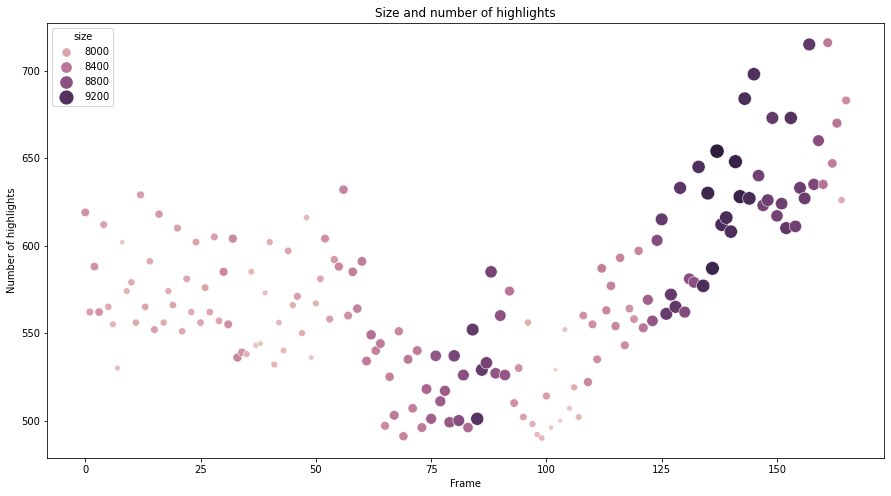

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
sns.scatterplot(
    data=df, x=list(df.index), y="number", hue="size", size="size",
    sizes=(20, 200), legend="auto"
)
ax.set_xlabel('Frame')
ax.set_ylabel('Number of highlights')
ax.set_title('Size and number of highlights')
plt.show()

In [ ]:
fame_color = np.stack(df['main_color'].apply(lambda x: np.array(x)).values).reshape(1,166,3)

/usr/local/lib/python3.9/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


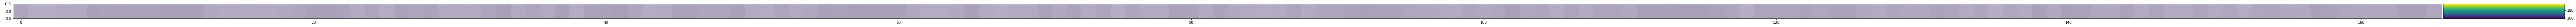

In [ ]:
# изменение цвета пены во времени
fig, ax = plt.subplots(figsize = (100,20))
io.imshow(fame_color)